# **Full Code**

### **Initial Analysis**

In [ ]:
!pip install opencv-python-headless

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD, RMSprop, Adagrad, Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
base_dir = '/content/drive/MyDrive/Need/Up/Melanie/Dataset'

AiArt_dir = os.path.join(base_dir, 'AiArtData')
RealArt_dir = os.path.join(base_dir, 'RealArt')

print('total training Ai images:', len(os.listdir(AiArt_dir)))
print('total training Real images:', len(os.listdir(RealArt_dir)))


total training Ai images: 539
total training Real images: 436


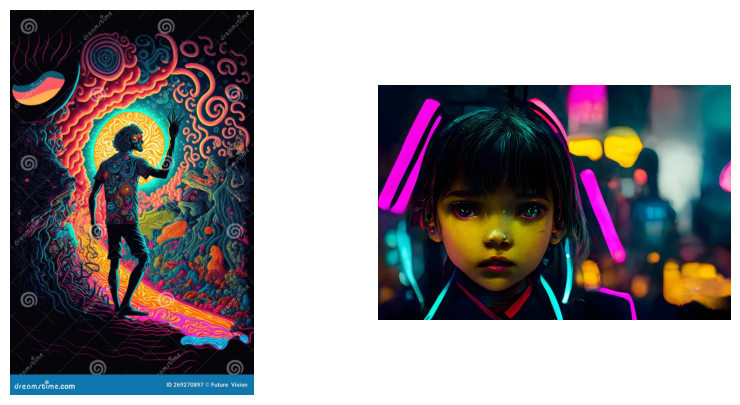

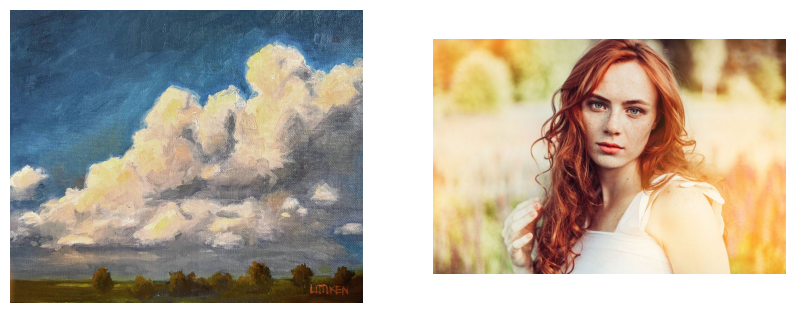

In [ ]:
def display_images(image_paths):
    plt.figure(figsize=(10, 5))
    for i, img_path in enumerate(image_paths):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        plt.subplot(1, len(image_paths), i+1)
        plt.imshow(img)
        plt.axis('off')
    plt.show()

ai_art_files = os.listdir(AiArt_dir)[:2]
real_art_files = os.listdir(RealArt_dir)[:2]

display_images([os.path.join(AiArt_dir, fname) for fname in ai_art_files])
display_images([os.path.join(RealArt_dir, fname) for fname in real_art_files])

In [ ]:
ai_art_count = len(os.listdir(AiArt_dir))
real_art_count = len(os.listdir(RealArt_dir))

print(f'Total training AiArt images: {ai_art_count}')
print(f'Total training RealArt images: {real_art_count}')

# Checking for imbalance
if abs(ai_art_count - real_art_count) / max(ai_art_count, real_art_count) > 0.2:
    print("Dataset is significantly imbalanced.")
else:
    print("Dataset is relatively balanced.")


Total training AiArt images: 539
Total training RealArt images: 436
Dataset is relatively balanced.


In [ ]:
# Example for analyzing image dimensions
from PIL import Image

first_ai_image = Image.open(os.path.join(AiArt_dir, ai_art_files[0]))
print(f"First AiArt image dimensions: {first_ai_image.size}")

first_real_image = Image.open(os.path.join(RealArt_dir, real_art_files[0]))
print(f"First RealArt image dimensions: {first_real_image.size}")


First AiArt image dimensions: (1067, 1690)
First RealArt image dimensions: (1068, 889)


In [ ]:
# Data Augmentation and Data Splitting
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.25
)

# Training Data Generator
train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(255, 255),
    class_mode='categorical',
    batch_size=64,
    subset='training'  # Specify this is training data
)

# Validation Data Generator
validation_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(255, 255),
    class_mode='categorical',
    batch_size=16,
    subset='validation'  # Specify this is validation data
)


Found 728 images belonging to 2 classes.
Found 242 images belonging to 2 classes.


### **CNN**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

model = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(255, 255, 3)),
    keras.layers.MaxPooling2D(2, 2),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D(2, 2),
    keras.layers.Conv2D(128, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D(2, 2),
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dropout(0.7),
    keras.layers.Dense(2, activation='softmax')
])

model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 253, 253, 32)      896       
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 126, 126, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 124, 124, 64)      18496     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 30, 30, 128)      

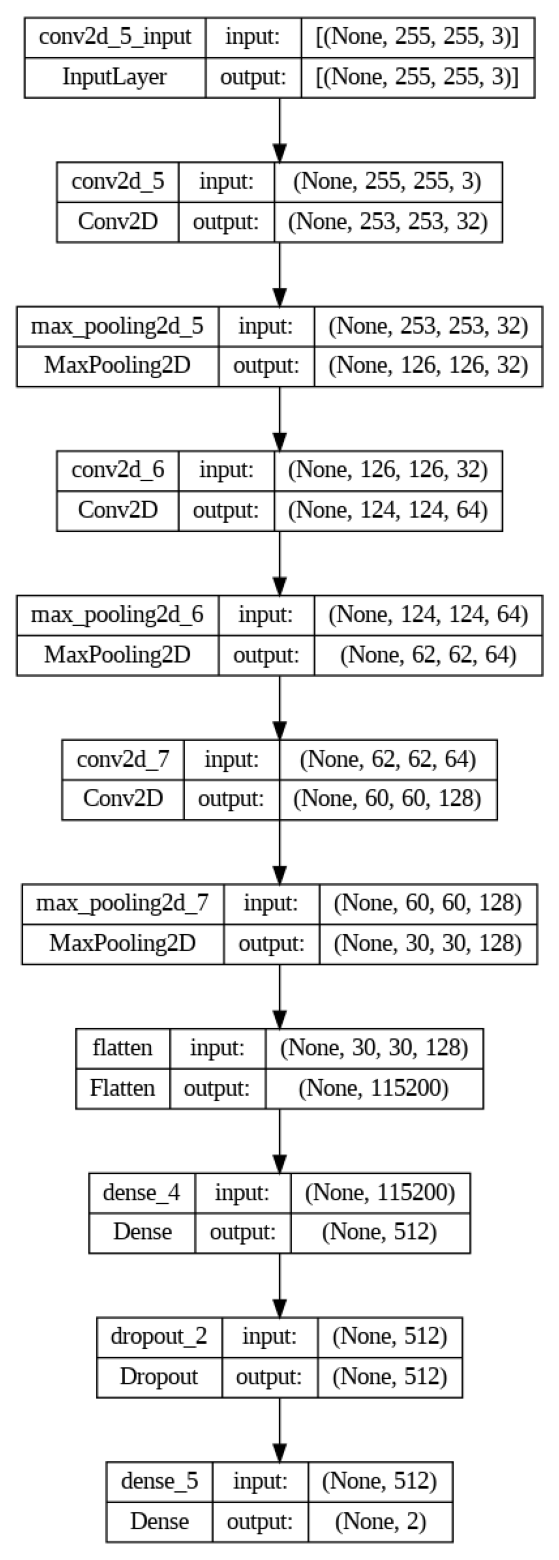

In [ ]:
from tensorflow.keras.utils import plot_model
# Save the model summary as an image
plot_model(model, to_file='optimized_model_summary.png', show_shapes=True, show_layer_names=True)

# Display the image with adjusted figure size
img = plt.imread('optimized_model_summary.png')
plt.figure(figsize=(40, 20))
plt.imshow(img)
plt.axis('off')
plt.show()

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.00001)

In [ ]:
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=validation_generator,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/100
12/12 [==============================] - 162s 13s/step - loss: 0.6880 - accuracy: 0.5591 - val_loss: 0.6456 - val_accuracy: 0.5868 - lr: 0.0010
Epoch 2/100
12/12 [==============================] - 156s 13s/step - loss: 0.6658 - accuracy: 0.6209 - val_loss: 0.6263 - val_accuracy: 0.6405 - lr: 0.0010
Epoch 3/100
12/12 [==============================] - 158s 13s/step - loss: 0.6713 - accuracy: 0.5852 - val_loss: 0.6497 - val_accuracy: 0.5537 - lr: 0.0010
Epoch 4/100
12/12 [==============================] - 158s 13s/step - loss: 0.6616 - accuracy: 0.5577 - val_loss: 0.6310 - val_accuracy: 0.6198 - lr: 0.0010
Epoch 5/100
12/12 [==============================] - 155s 13s/step - loss: 0.6451 - accuracy: 0.6291 - val_loss: 0.6363 - val_accuracy: 0.6488 - lr: 0.0010
Epoch 6/100
12/12 [==============================] - 159s 13s/step - loss: 0.6457 - accuracy: 0.6470 - val_loss: 0.6177 - val_accuracy: 0.6488 - lr: 0.0010
Epoch 7/100
12/12 [==============================] - 157s 13s/st

In [ ]:
# After training, save the model to an H5 file
model.save('my_model.h5')
print("Model saved as my_model.h5")


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved as my_model.h5


In [ ]:
from tensorflow.keras.models import load_model
loaded_model = load_model('my_model.h5')
print("Model loaded successfully")

In [ ]:
epochs_completed = len(history.history['loss'])
print(f"Training stopped at epoch: {epochs_completed}")

Training stopped at epoch: 91


In [ ]:
RMSprop_loss = history.history['loss']
RMSprop_acc = history.history['accuracy']

print(RMSprop_loss)
print(RMSprop_acc)

[0.6880286335945129, 0.6657668948173523, 0.6712638735771179, 0.6616228222846985, 0.6451030969619751, 0.6456633806228638, 0.634701669216156, 0.6272968649864197, 0.6287978887557983, 0.6394824385643005, 0.645717203617096, 0.6311076879501343, 0.6186724901199341, 0.6104450821876526, 0.6632458567619324, 0.6326071619987488, 0.6249563097953796, 0.6036439538002014, 0.6017612218856812, 0.5949121713638306, 0.5931723713874817, 0.5867299437522888, 0.5870313048362732, 0.6041979193687439, 0.6182705163955688, 0.5966387391090393, 0.587593138217926, 0.578112781047821, 0.5741744637489319, 0.5563110709190369, 0.5665565133094788, 0.544461190700531, 0.5296487212181091, 0.568473756313324, 0.5514943599700928, 0.5553449988365173, 0.5252128839492798, 0.5284751653671265, 0.5540794134140015, 0.5541723370552063, 0.5480327606201172, 0.5293970704078674, 0.5141739845275879, 0.5093559622764587, 0.5187875032424927, 0.5013622641563416, 0.4844982326030731, 0.476641446352005, 0.48547518253326416, 0.5044302940368652, 0.486

In [ ]:
val_loss, val_accuracy = model.evaluate(validation_generator, verbose=0)
print(f"Optimizer: Adam, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")

Optimizer: RMSprop, Validation Loss: 0.5519585609436035, Validation Accuracy: 0.7685950398445129


In [ ]:
loss, accuracy = model.evaluate(train_generator, verbose=0)
print(f"Optimizer: Adam, Training Loss: {loss}, Training Accuracy: {accuracy}")

Optimizer: Adam, Training Loss: 0.4555266797542572, Training Accuracy: 0.7967032790184021


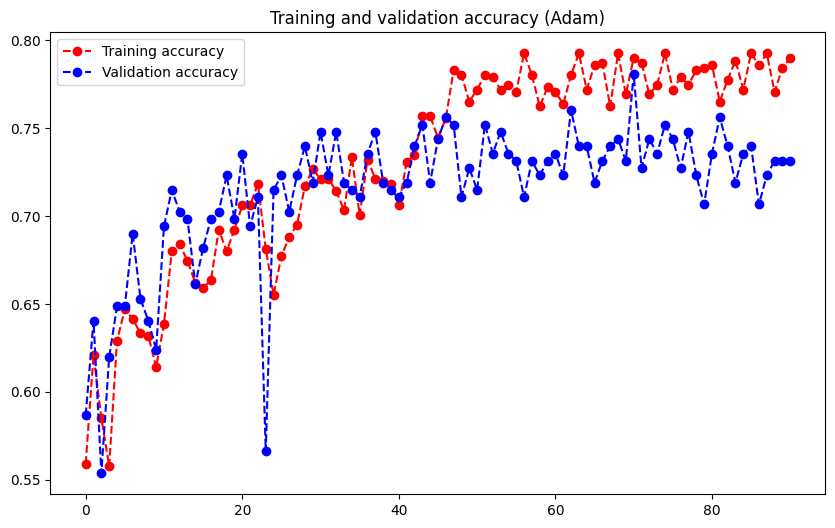

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.figure(figsize=(10, 6))
plt.plot(epochs, acc, 'r', label='Training accuracy', marker = 'o', linestyle = 'dashed')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy', marker = 'o', linestyle = 'dashed')
plt.title('Training and validation accuracy (Adam)')
plt.legend(loc=0)

plt.show()

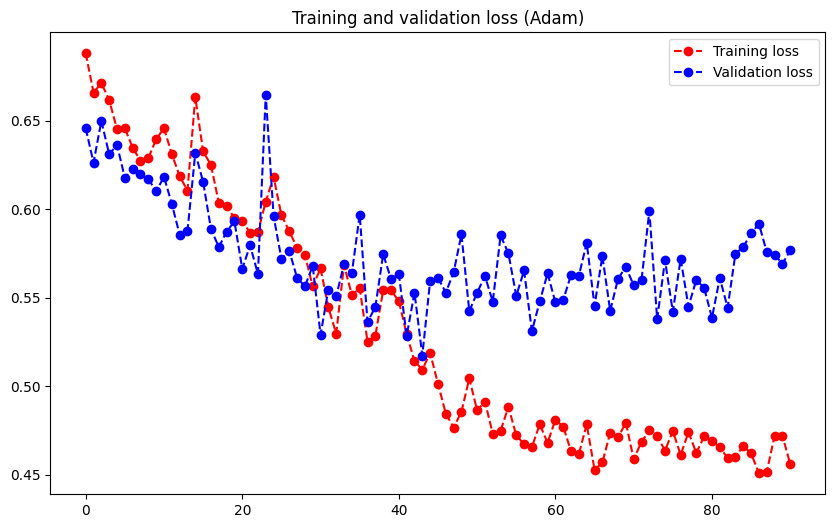

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, 'r', label='Training loss', marker = 'o', linestyle = 'dashed')
plt.plot(epochs, val_loss, 'b', label='Validation loss', marker = 'o', linestyle = 'dashed')
plt.title('Training and validation loss (Adam)')
plt.legend(loc=0)

plt.show()

### **Prediction**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Function to preprocess and predict an image
def predict_image(model, img_path):
    img = image.load_img(img_path, target_size=(255, 255))  # Load and resize the image
    img_array = image.img_to_array(img)  # Convert the image to numpy array
    img_array = np.expand_dims(img_array, axis=0)  # Add a batch dimension
    img_array /= 255.0  # Scale the image

    prediction = model.predict(img_array)  # Predict the class of the image
    return prediction




1/1 [==============================] - 0s 72ms/step


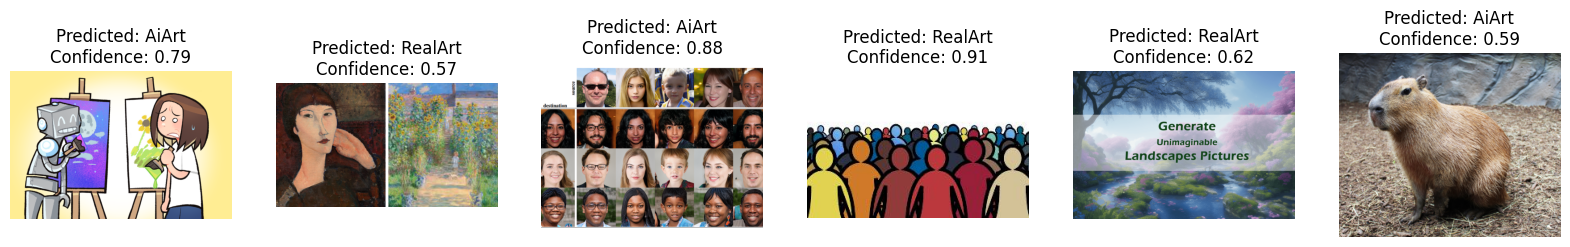

In [ ]:
# List of image paths to predict
image_paths = [
    os.path.join(AiArt_dir, 'aiart.png'),
    os.path.join(RealArt_dir, 'famous-paintings.png'),
    os.path.join(AiArt_dir, 'nvidia_ai.png'),
    os.path.join(RealArt_dir, 'images37.jpg'),
    os.path.join(AiArt_dir, 'landscapes.png'),
    os.path.join(RealArt_dir, 'capy1.png'),
]

# Display and predict each image
plt.figure(figsize=(20, 10))
for i, img_path in enumerate(image_paths):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    plt.subplot(1, len(image_paths), i+1)
    plt.imshow(img)
    plt.axis('off')

    # Predict the image
    prediction = predict_image(model, img_path)
    plt.title(f'Predicted: {"AiArt" if np.argmax(prediction) == 0 else "RealArt"}\nConfidence: {np.max(prediction):.2f}')

plt.show()